In [2]:
import jax
import jax.numpy as jnp
from tqdm import tqdm
import netket as nk
# import netket_pro as nkp
import matplotlib.pyplot as plt
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
from grad_sample.utils.plotting_setup import *

In [5]:
# model_key = "heisenberg1d_1.0_s0"
# L=14

model_key = 'ising_1.0'
L=3

In [6]:
import math
math.factorial(14)/(math.factorial(7)**2)

3432.0

In [7]:
def plot_multi_alpha(alpha_max, strategy="curved_dist", n_err=9, model_key="ising_1.0", L=3):
    alpha_l = range(1, alpha_max)
    dict_l = []
    colors = sns.color_palette("colorblind", alpha_max)
    cmap = plt.cm.colors.ListedColormap(colors)
    for alpha in alpha_l:
        path= f"/scratch/.amisery/grad_sample/{model_key}/L{L}/RBM/alpha{alpha}/saved_10_10/out_analysis_oneshot_{strategy}.npz"
        dict_l.append(jnp.load(path, allow_pickle=True)["arr_0"].item())
    
    delta= dict_l[0]["commons"]["delta"]
    fig, axes = plt.subplots(1, n_err-1, figsize=(20,3))

    for j in range(1,n_err):
        for i in range(len(alpha_l)): 
            out_dict = dict_l[i]
            keys = list(out_dict.keys())[1:]
            # keys  = jnp.argwhere(keys.type == int)
            if j < len(keys):
                alpha = alpha_l[i]
                axes[j-1].plot(out_dict[keys[j]]["infid_ev"], label = r"$\alpha = %d$"%alpha, color= cmap(i))
                axes[j-1].set_yscale("log")
                axes[j-1].set_title(r"$\sigma_{rel} \approx 10^{-%d},\newline \delta =%.1e$"%(j, out_dict[keys[j]]["delta"]), fontsize=15)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.98,0.9))
    fig.suptitle(r"Robustness of $\frac{FS(\ket{\psi_{\theta+\delta \dot{\theta}}}, (I -\delta H) \ket{\psi_\theta})}{FS(\ket{\psi_{\theta}}, (I -\delta H) \ket{\psi_\theta})}$ to sample pruning, $\delta = %.2e$"%delta, y=1.3, fontsize=23)
    plt.show()
    plt.clf()

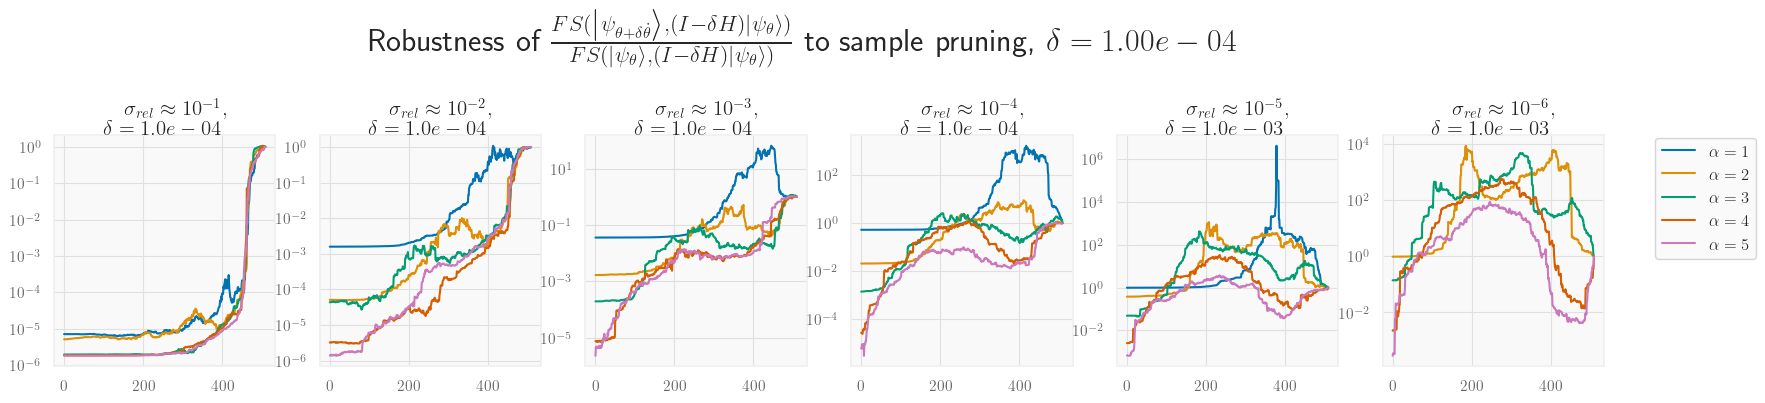

<Figure size 1000x600 with 0 Axes>

In [8]:
plot_multi_alpha(6, model_key=model_key, L=L, n_err=7)

In [69]:
# plot_multi_alpha(8, "infidelity")
from jax.numpy.linalg import pinv
from grad_sample.utils.distances import fs_dist
def pdf(dict, vals):
    return dict["pdf"][vals], r"$|\psi(\sigma)|^2$"

def gradient(dict, vals):
    jac_c = dict["jac"] - jnp.sum(dict["pdf"][:,None]*dict["jac"], axis=0)
    return jnp.sum(jac_c, axis=0)[vals], "gradient"

def hpsi(dict, vals):
    v_arr = dict["vs_arr"]
    hpsi = dict["Hloc"]*v_arr
    return hpsi[vals], r"$H \ket{\psi}$"

def hloc(dict, vals):
    hloc = dict["Hloc"] - jnp.sum(dict["pdf"]*dict["Hloc"])
    return hloc[vals], r"$\Delta H_{loc}(\sigma)$"
    
def ntk(dict, vals):
    pdf = dict["pdf"]
    ret = []
    for i in  range(1,len(vals), len(vals)//100):
        pdf_r = pdf.at[vals[:i]].set(0)
        pdf_r = pdf_r / jnp.sum(pdf_r)
        jac_c = dict["jac"] - jnp.sum(pdf_r[:,None]*dict["jac"], axis=0)
        ntk = jac_c @ jac_c.conj().T
        hpsi = dict["Hloc"]*dict["vs_arr"]
        delta_H_psi = hpsi - jnp.sum(pdf_r*hpsi)
        ret.append(fs_dist(delta_H_psi, ntk @ delta_H_psi))

    return jnp.array(ret), r"$FS(\Delta H \ket{\psi},  K_S \Delta H \ket{\psi})$"

def ntk_inv(dict, vals):
    pdf = dict["pdf"]
    ret = []
    for i in  range(1,len(vals), len(vals)//10):
        pdf_r = pdf.at[vals[:i]].set(0)
        pdf_r = pdf_r / jnp.sum(pdf_r)
        jac_c = jnp.sqrt(pdf_r[:,None]) *(dict["jac"] - jnp.sum(pdf_r[:,None]*dict["jac"], axis=0))
        ntk = jac_c @ jac_c.conj().T
        hpsi = dict["Hloc"]*dict["vs_arr"]
        delta_H_psi = hpsi - jnp.sum(pdf_r*hpsi)
        inv  = pinv(ntk)
        ret.append(fs_dist(delta_H_psi, inv @ delta_H_psi))
    return jnp.array(ret), r"$\bra{\psi} \Delta H K_s^{-1} \Delta H \ket{\psi}$"

def ntk_sr(dict, vals):
    pdf = dict["pdf"]
    ret = []
    for i in  range(1,len(vals), len(vals)//10):
        pdf_r = pdf.at[vals[:i]].set(0)
        pdf_r = pdf_r / jnp.sum(pdf_r)
        jac_c = (dict["jac"] - jnp.sum(pdf_r[:,None]*dict["jac"], axis=0))
        ntk = jac_c @ jac_c.conj().T
        hpsi = dict["Hloc"]*dict["vs_arr"]
        delta_H_psi = hpsi - jnp.sum(pdf_r*hpsi)
        inv = 1/(1e-10)*ntk @ pinv(jnp.eye(ntk.shape[0]) + ntk/(1e-10))
        ret.append(fs_dist(pdf_r * delta_H_psi, pdf_r * inv @ delta_H_psi))
    return jnp.array(ret), r"$FS(\Delta H \ket{\psi}, (I + \lambda K_S^{-1})^{-1} \Delta H \ket{\psi})$"

def ntk_sq(dict, vals):
    pdf = dict["pdf"]
    ret = []
    for i in  range(1,len(vals), len(vals)//100):
        pdf_r = pdf.at[vals[:i]].set(0)
        pdf_r = pdf_r / jnp.sum(pdf_r)
        jac_c = jnp.sqrt(jnp.sqrt(pdf_r[:,None])) * (dict["jac"] - jnp.sum(pdf_r[:,None]*dict["jac"], axis=0))
        # jac_c = orth(jac_c)

        # print(jac_orth.shape)
        ntk = jac_c @ jac_c.conj().T
        # qgt = jac_c.conj().T @ jac_c
        # ntk_orth = jac_c @ pinv(qgt) @ jac_c.conj().T
        ntk_sq = ntk @ ntk
        # print(ntk_sq / ntk_orth)
        hpsi = dict["Hloc"]*dict["vs_arr"]
        delta_H_psi = hpsi - jnp.sum(pdf_r*hpsi)
        ret.append((delta_H_psi.conj().transpose() @ ntk_sq @ delta_H_psi)/(delta_H_psi.conj().transpose() @ delta_H_psi))
        
    return  jnp.array(ret), r"$\frac{\bra{\psi} \Delta H K_s^2 \Delta H \ket{\psi}}{\bra{\psi} \Delta H \Delta H \ket{\psi}}$"

def ntk_orth(dict, vals):
    pdf = dict["pdf"]
    ret = []

    v_arr = dict["vs_arr"]
    for i in  range(1,len(vals), len(vals)//10):
        pdf_r = pdf.at[vals[:i]].set(0)
        nf = jnp.sum(pdf_r)
        pdf_r = pdf_r / nf
        v_arr_r = v_arr.at[vals[:i]].set(0)/nf
        jac_c = v_arr_r[:,None]*(dict["jac"]) - jnp.sum(pdf_r[:,None]*(dict["jac"]*v_arr_r[:,None]), axis=0)
        # jac_c = pdf_r[:,None]*(dict["jac"] - jnp.sum(pdf_r[:,None]*dict["jac"], axis=0))
        # jac_c = orth(jac_c)

        # print(jac_orth.shape)
        # ntk = jac_c @ jac_c.conj().T
        qgt = jac_c.conj().T @ jac_c
        ntk_orth = jac_c @ pinv(qgt) @ jac_c.conj().T
        ntk_orth_sq = ntk_orth.conj().T @ ntk_orth
        # print(ntk_sq / ntk_orth)
        # hpsi = dict["Hloc"]*dict["vs_arr"]
        hpsi = dict["Hloc"]*v_arr_r
        delta_H_psi = hpsi - jnp.sum(pdf_r*hpsi)
        ret.append((delta_H_psi @ ntk_orth_sq @ delta_H_psi)/(delta_H_psi @ delta_H_psi))
        
    return  jnp.array(ret), r"$\frac{\bra{\psi} \Delta H K_{s,orth}^2\Delta H \ket{\psi}}{\bra{\psi}\Delta H^2 \ket{\psi}}$"

In [51]:
def plot_multi_alpha_val(alpha_max, key="ntk_sq", center=False, n_err = 5, strategy="curved_dist", model_key="ising_1.0", L=3):
    alpha_l = range(1, alpha_max)
    dict_l = []
    colors = sns.color_palette("colorblind", alpha_max)
    cmap = plt.cm.colors.ListedColormap(colors)
    for alpha in alpha_l:
        path= f"/scratch/.amisery/grad_sample/{model_key}/L{L}/RBM/alpha{alpha}/saved_10_4/out_analysis_oneshot_{strategy}.npz"
        dict_l.append(jnp.load(path, allow_pickle=True)["arr_0"].item())
    n_err = n_err
    delta= dict_l[0]["commons"]["delta"]
    fig, axes = plt.subplots(len(alpha_l), n_err-1, figsize=(20,20))

    for j in tqdm(range(1,n_err)):
        for i in tqdm(range(len(alpha_l))): 
            out_dict = dict_l[i]
            keys = list(out_dict.keys())[1:]
            # keys  = jnp.argwhere(keys.type == int)
            if j < len(keys):
                vals = out_dict[keys[j]]["in_idx"]
                obs, name = globals()[key](out_dict[keys[j]], vals)
                alpha = alpha_l[i]
                if center:
                    pdf =  obs = out_dict[keys[j]]["pdf"]
                    obs = obs - jnp.sum(obs*pdf)
                axes[i,j-1].scatter(jnp.arange(len(obs)), jnp.abs(obs), label = r"$\alpha = %d$"%alpha, color= cmap(i))
                axes[i,j-1].set_yscale("log")
                axes[i, j-1].set_ylabel(name)
                axes[i,j-1].set_title(r"$\sigma_{rel} \approx 10^{-%d},\newline \delta =%.1e$"%(j, out_dict[keys[j]]["delta"]), fontsize=15)
    handles, labels = [], []
    for ax in axes.flat:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    unique = dict(zip(labels, handles))
    fig.legend(unique.values(), unique.keys(), bbox_to_anchor=(0.98,0.9))
    fig.suptitle(name + " over pruning, for several relative errors and models", fontsize=20)
    plt.tight_layout()

In [11]:
# plot_multi_alpha_val(6, model_key=model_key, L=L, n_err=9, key="ntk_sr")

In [26]:
def plot_multi_alpha_val_one(alpha_max, key="ntk_sq", center=False, n_err = 5, strategy="curved_dist", model_key="ising_1.0", L=3, use_ordered_vals=False):
    alpha_l = range(1, alpha_max)
    dict_l = []
    colors = sns.color_palette("colorblind", alpha_max)
    cmap = plt.cm.colors.ListedColormap(colors)
    for alpha in alpha_l:
        path= f"/scratch/.amisery/grad_sample/{model_key}/L{L}/RBM/alpha{alpha}/saved_10_10/out_analysis_oneshot_{strategy}.npz"
        dict_l.append(jnp.load(path, allow_pickle=True)["arr_0"].item())
    n_err = n_err
    delta= dict_l[0]["commons"]["delta"]
    fig, axes = plt.subplots(1, n_err-1, figsize=(20,5))

    for j in range(1,n_err):
        for i in tqdm(range(len(alpha_l))): 
            out_dict = dict_l[i]
            keys = list(out_dict.keys())[1:]
            # keys  = jnp.argwhere(keys.type == int)
            if j < len(keys):
                vals = out_dict[keys[j]]["in_idx"]
                if use_ordered_vals:
                    vals = jnp.arange(512)
                obs, name = globals()[key](out_dict[keys[j]], vals)
                alpha = alpha_l[i]
                if center:
                    pdf =  obs = out_dict[keys[j]]["pdf"]
                    obs = obs - jnp.sum(obs*pdf)
                axes[j-1].scatter(jnp.arange(len(obs)), jnp.abs(obs), label = r"$\alpha = %d$"%alpha, color= cmap(i))
                axes[j-1].set_yscale("log")
                axes[j-1].set_ylabel(name)
                axes[j-1].set_title(r"$\sigma_{rel} \approx 10^{-%d},\newline \delta =%.1e$"%(j, out_dict[keys[j]]["delta"]), fontsize=15)
    handles, labels = [], []
    for ax in axes.flat:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    unique = dict(zip(labels, handles))
    fig.legend(unique.values(), unique.keys(), bbox_to_anchor=(1.01,0.9))
    fig.suptitle(name + " over pruning, for several relative errors and models", fontsize=20)
    plt.tight_layout()
    

100%|██████████| 7/7 [00:00<00:00, 27.16it/s]


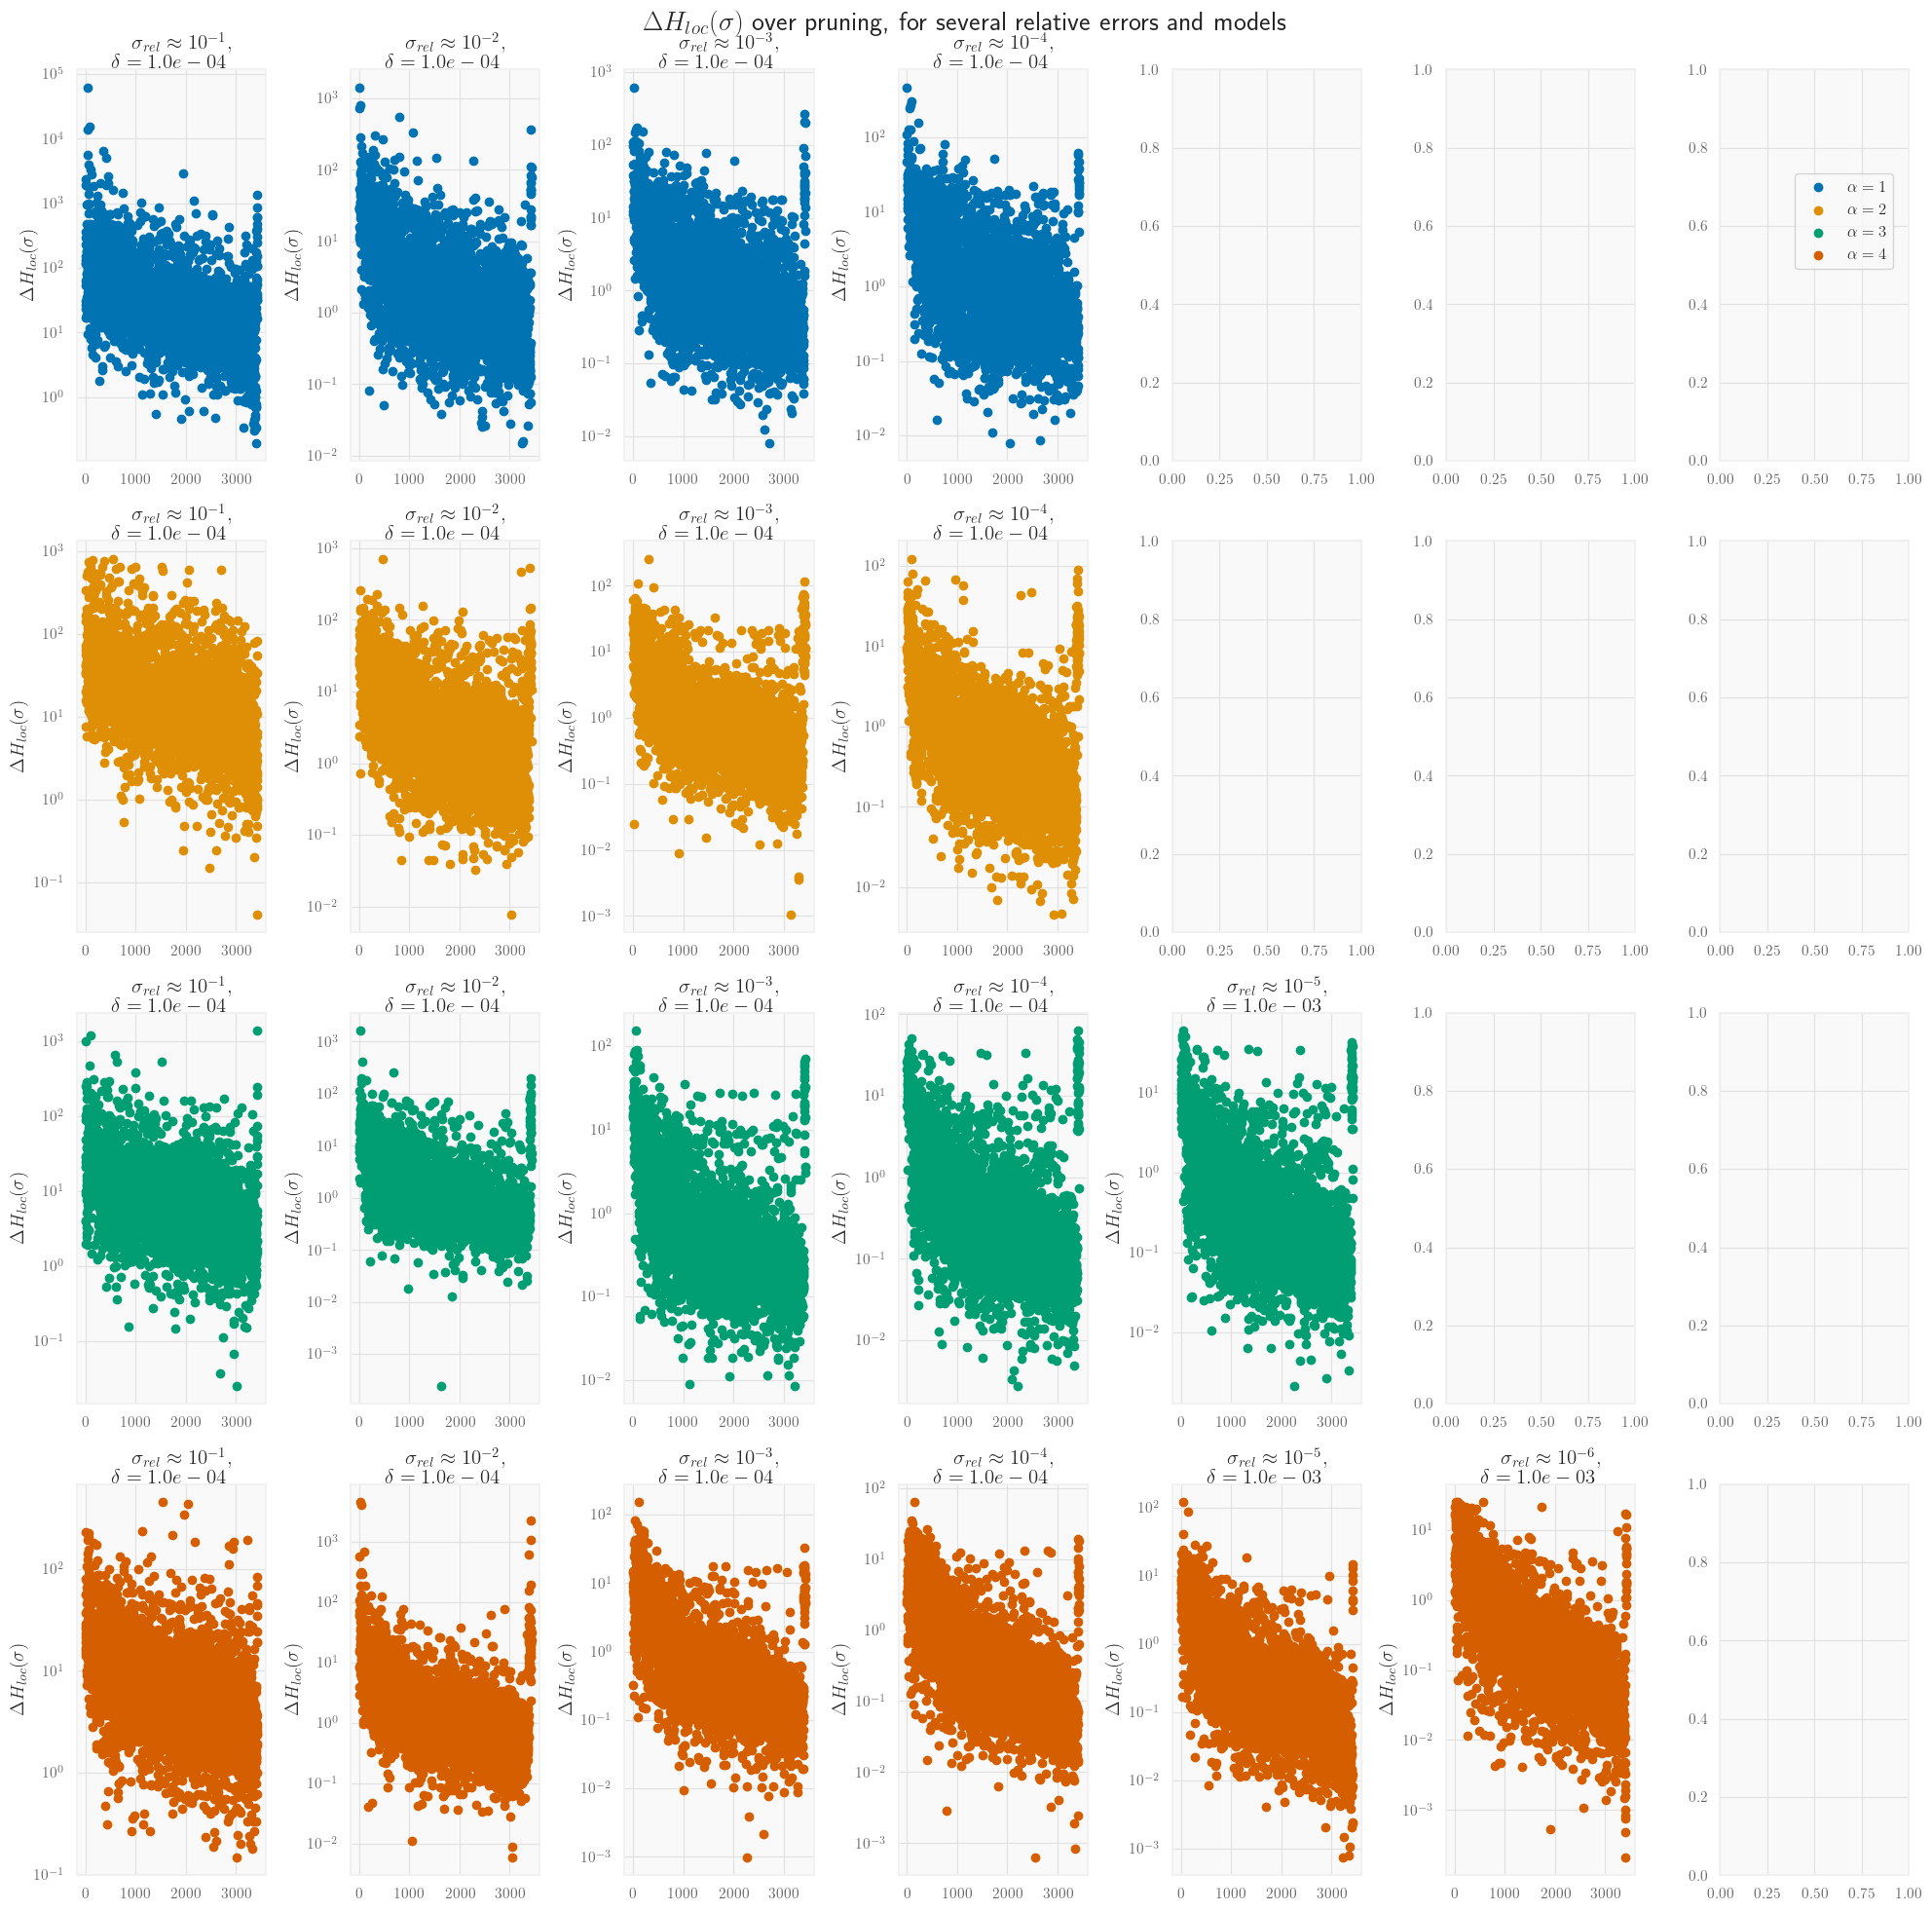

In [70]:
model_key = "heisenberg1d_1.0_s0"
L=14
plot_multi_alpha_val(5, model_key=model_key, L=L, n_err=8, key="hloc")

100%|██████████| 7/7 [01:09<00:00,  9.92s/it]


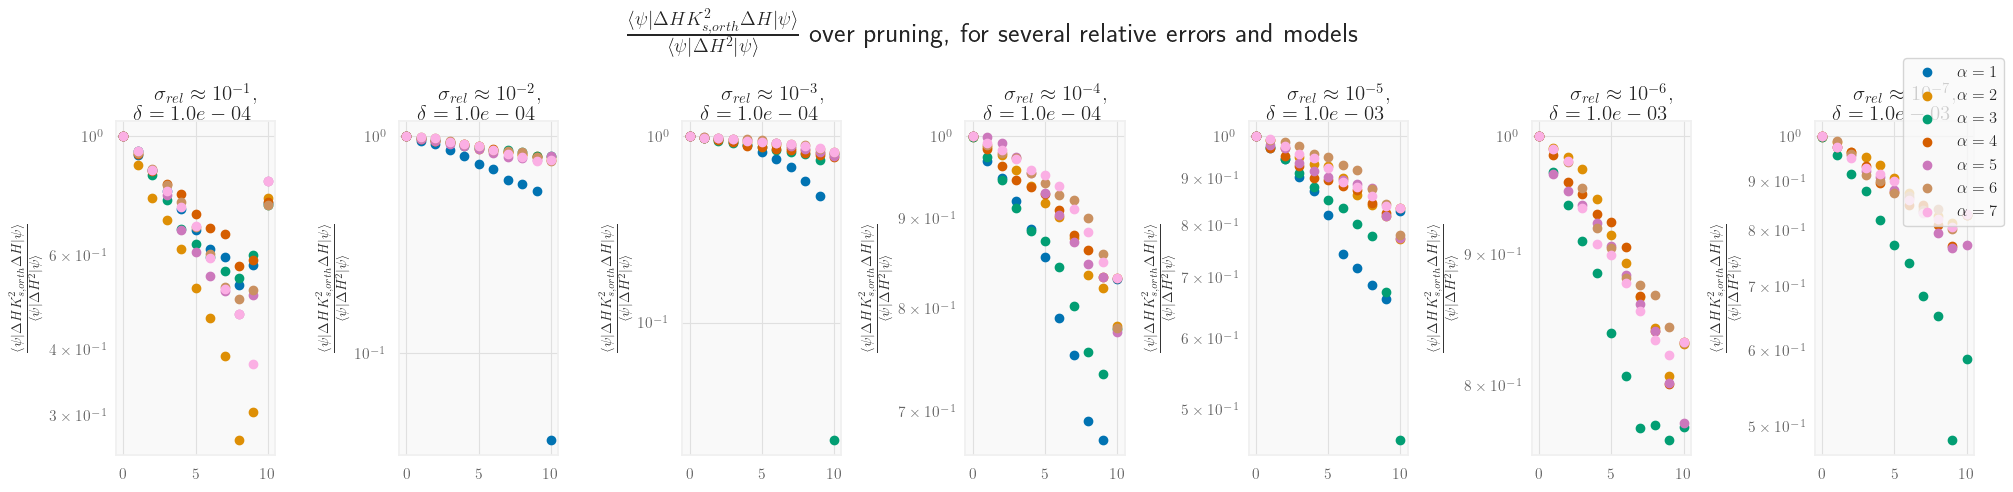

In [42]:
plot_multi_alpha_val_one(8, model_key=model_key, L=L, n_err=8, key="ntk_orth")

100%|██████████| 4/4 [00:15<00:00,  3.75s/it]


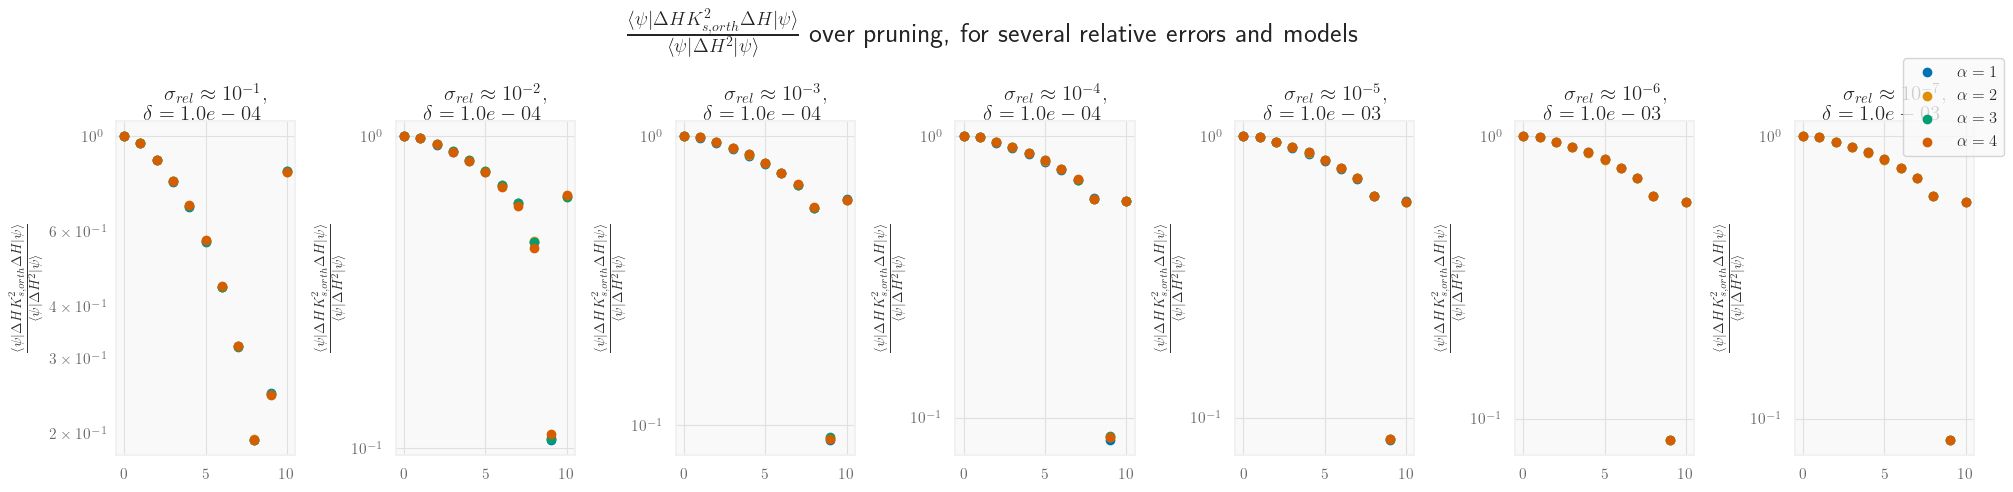

In [40]:
plot_multi_alpha_val_one(5, model_key=model_key, L=L, n_err=8, key="ntk_orth", use_ordered_vals=True)

In [ ]:
plot_multi_alpha_val_one(5, model_key=model_key, L=L, n_err=3, key="ntk_orth")

In [14]:
plot_multi_alpha_val(3, "Hloc", strategy="curved_dist", center=False, model_key=model_key, L=L)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/.amisery/grad_sample/ising_1.0/L3/RBM/alpha1/saved_10_4/out_analysis_oneshot_curved_dist.npz'